**HERE IS THE CODE FOR PROCESSING AND PREDICTING 1 COMPLETE ELECTRO L2 IMAGE**

**IMPORT ALL NEEDED LIBS**

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from PIL import Image
from tqdm import tqdm
from timeit import default_timer as timer 
from PIL import Image
import numpy as np
import gc
import os
import warnings
import matplotlib.pyplot as plt
from torch import nn
from IPython.display import clear_output
from torcheval.metrics.functional import multiclass_f1_score
from copy import deepcopy
import random
from skimage.transform import resize as interp_resize
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as A
import tifffile as tff
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
np.set_printoptions(threshold=1e7)
# ITS RECOMMENDED TO USE CUDA DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
your_current_dir = os.getcwd()
print('Your device :',device)
print('Your current dir of this .ipynb file',your_current_dir)

Your device : cuda
Your current dir of this .ipynb file C:\Users\nikita.belyakov\Desktop\5th_cource\MSU_AI\course_work\python_notebooks\INFERENCE


**YOU CAN JUST PLACE ALL UNARCHIVER INFERENCE DATA & MODEL FROM GITHUB WITH THIS .IPYNB FILE IN ONE FOLDER AND RUN ALL**

**FIX RANDOM SEED EVERYWHERE TO MAKE RESULTS STABLE**

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(seed=42)

**INITIALIZE ALL NEEDED FUNCTIONS FOR POSTPROCESSING PREDICTS OF MODEL**

In [4]:
def batch_to_img(xb, idx=0):
    img = np.array(xb.squeeze(0))
    return np.array(img.transpose((1,2,0))*255)
def predb_to_mask(predb,idx=0):
    p = torch.functional.F.softmax(predb.squeeze(0), 0)
    return p.argmax(0).cpu()
def inverse_normalize(tensor,mean,std,num_shannels =5):
    tensor = tensor.detach().cpu().numpy()
    for i in range(num_shannels):
        tensor[i] = (tensor[i] * std[i]) + mean[i]
    tensor = np.clip(tensor, 0, 1)
    tensor = (tensor * 255).astype(np.uint8)
    return tensor
def open_sample_as_pil_no_norm(datacube):
    inversed_rgb = (datacube[0:3])
    rgb = np.dstack((inversed_rgb[2,:,:],inversed_rgb[1,:,:],inversed_rgb[0,:,:]))*255
    return rgb.astype('uint8')

**SPLITTING ELECTRO L2 STACK OF 9 CHANNELS TO PATCHES AND SAVE THEM FOR DATASET**

In [5]:
def split_rgb_aux_stack(stack, patch_size,dir_name):
    print('init stack shape =', stack.shape)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if stack.shape[0]%patch_size!=0:
    # Calculate the number of patches in each dimension
        if stack.shape[1]==5424:
            print('############ half of img only!!!!!!!')
            stack = stack[48:-48,48:,:]
        else:
            print('############full img processing!!!!!!!')
            stack = stack[48:-48,48:-48,:]
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    patches,nonempty_idxs = [],[]
    for i in tqdm(range(n_patches_h)):
        for j in range(n_patches_w):
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            b_patch = patch[:,:,0].flatten()
            empty_flag = np.sum(b_patch)
            if empty_flag>1000000:
                nonempty_idxs.append(n_patches_w*i+j)
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.tif'
            tff.imwrite(patch_name, patch)
    print('############## rgb and geoinfo successfully splitted! ####################')
    return nonempty_idxs
def split_BT_stack(stack, patch_size,dir_name):
    print('init stack shape =', stack.shape)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if stack.shape[0]%patch_size!=0:
        if stack.shape[1]==5424:
            print('############ half of img only!!!!!!!')
            stack = stack[48:-48,48:,:]
        else:
            print('############full img processing!!!!!!!')
            stack = stack[48:-48,48:-48,:]
    # Calculate the number of patches in each dimension
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    for i in tqdm(range(n_patches_h)):
        for j in range(n_patches_w):
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.tif'
            tff.imwrite(patch_name, patch)
    print('############## BT successfully splitted! ####################')

**SPLITTING RGB & GEOINFO TO PATCHES**

In [6]:
# your_current_dir
patch_size = 224
times = ['1700']
apply_zsa = True
cut_mode = False
for time in (times): # no ZSA img
    if apply_zsa == False:
        img_Electro_L2 = tff.imread(your_current_dir+'/rgb_raw_'+time+'.tif')
    else:# with ZSA img
        img_Electro_L2 = tff.imread(your_current_dir+'/rgb_ZSA_'+time+'.tif')
    r_Electro_L2,g_Electro_L2,b_Electro_L2 = img_Electro_L2[:,:,0],img_Electro_L2[:,:,1],img_Electro_L2[:,:,2]
    # for ELECTRO in 4 km res
    if r_Electro_L2.shape[-1] == 2784:
        print('......reshaping electro img to needed 1 km res......')
        padding = (11136-10848)//8
        r_Electro_L2 = r_Electro_L2[padding:-padding,padding:-padding]
        g_Electro_L2 = g_Electro_L2[padding:-padding,padding:-padding]
        b_Electro_L2 = b_Electro_L2[padding:-padding,padding:-padding]
        r_Electro_L2 = np.array(Image.fromarray(r_Electro_L2).resize((10848,10848),resample=Image.NEAREST)).astype(np.uint8)
        g_Electro_L2 = np.array(Image.fromarray(g_Electro_L2).resize((10848,10848),resample=Image.NEAREST)).astype(np.uint8)
        b_Electro_L2 = np.array(Image.fromarray(b_Electro_L2).resize((10848,10848),resample=Image.NEAREST)).astype(np.uint8)
        # left only half that can be matched with cloud mask from GOES-16
        # cutting half of img for finetunning dataset!!!!!!!!!!!!
        if cut_mode:
            cut_fac = 2
            r_Electro_L2 = r_Electro_L2[:,:int(10848/cut_fac)]
            g_Electro_L2 = g_Electro_L2[:,:int(10848/cut_fac)]
            b_Electro_L2 = b_Electro_L2[:,:int(10848/cut_fac)]
        print('......resampled to the needed res and shape =',r_Electro_L2.shape)
    lon_Electro_L2 = np.load(your_current_dir+'/lon_1km_res.npy')
    lat_Electro_L2 = np.load(your_current_dir+'/lat_1km_res.npy')
    dem_Electro_L2 = tff.imread(your_current_dir+'/dem_tif.tif')
    dem_Electro_L2 = interp_resize(dem_Electro_L2, (10848,10848))
    # left only half that can be matched with cloud mask from GOES-16
    # cutting half of img for finetunning dataset!!!!!!!!!!!!
    if cut_mode:
        lon_Electro_L2 = lon_Electro_L2[:,:int(10848/cut_fac)]
        lat_Electro_L2 = lat_Electro_L2[:,:int(10848/cut_fac)]
        dem_Electro_L2 = dem_Electro_L2[:,:int(10848/cut_fac)]
    stack_6_ch = np.dstack([b_Electro_L2,g_Electro_L2,r_Electro_L2,lon_Electro_L2,lat_Electro_L2,dem_Electro_L2])
    if apply_zsa:
        nonempty_idxs_path = your_current_dir+'/nonempty_idxs_folder_ZSA/'
        if not os.path.exists(nonempty_idxs_path): os.makedirs(nonempty_idxs_path)
        nonempty_idxs_name = nonempty_idxs_path+'nonempty_idxs_electro_l2_'+time+'.npy'
        dir_name = your_current_dir+'/all_patch_folder_ZSA/patches_rgb_aux_electro_l2_'+time+'/'
    else:
        nonempty_idxs_path = your_current_dir+'/nonempty_idxs_folder/'
        if not os.path.exists(nonempty_idxs_path): os.makedirs(nonempty_idxs_path)
        nonempty_idxs_name = nonempty_idxs_path+'nonempty_idxs_electro_l2_'+time+'.npy'
        dir_name = your_current_dir+'/all_patch_folder/patches_rgb_aux_electro_l2_'+time+'/'
    nonempty_idxs_Electro_L2 = split_rgb_aux_stack(stack_6_ch, patch_size,dir_name=dir_name)
    np.save(nonempty_idxs_name,np.array(nonempty_idxs_Electro_L2))
    #clear memory
    img_Electro_L2=None
    b_Electro_L2,g_Electro_L2,r_Electro_L2,lon_Electro_L2,lat_Electro_L2,dem_Electro_L2 = None,None,None,None,None,None
    stack_6_ch = None
    print('num of non-empty patches =',len(nonempty_idxs_Electro_L2))

......reshaping electro img to needed 1 km res......
......resampled to the needed res and shape = (10848, 10848)
init stack shape = (10848, 10848, 6)
############full img processing!!!!!!!
n_patches_h,n_patches_w 48 48


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.53it/s]


############## rgb and geoinfo successfully splitted! ####################
num of non-empty patches = 1327


**SPLITTING BT of the same img TO PATCHES**

In [7]:
patch_size = 224
times = ['1700']
cut_mode = False
cut_fac = 2
for time in (times):
    BT_Electro_L2 = tff.imread(your_current_dir+'/BT_normed_'+time+'.tif')
    # for ELECTRO in 4 km res
    if BT_Electro_L2.shape[0] == 2784:
        print('.....RESAMPLING TO THE NEEDED 1 KM RES......')
        padding = (11136-10848)//8
        BT_Electro_L2 = BT_Electro_L2[padding:-padding,padding:-padding,:]
        BT_Electro_L2 = interp_resize(BT_Electro_L2, (10848,10848))
        # cut half of img for finetunning dataset
        if cut_mode:
            BT_Electro_L2 = BT_Electro_L2[:,:int(10848/cut_fac),:]
        print('.....resampled to the needed res and shape =',BT_Electro_L2.shape)
    dir_name = your_current_dir+'/all_patch_folder_BT/patches_BT_electro_l2_'+time+'/'
    split_BT_stack(BT_Electro_L2, patch_size,dir_name=dir_name)
    #clear memory
    BT_Electro_L2 = None

.....RESAMPLING TO THE NEEDED 1 KM RES......
.....resampled to the needed res and shape = (10848, 10848, 6)
init stack shape = (10848, 10848, 6)
############full img processing!!!!!!!
n_patches_h,n_patches_w 48 48


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:06<00:00,  7.60it/s]


############## BT successfully splitted! ####################


**CHECK IF SPLITTING ALL DATA TO PATCHES PROCCESSED CORRECTLY**

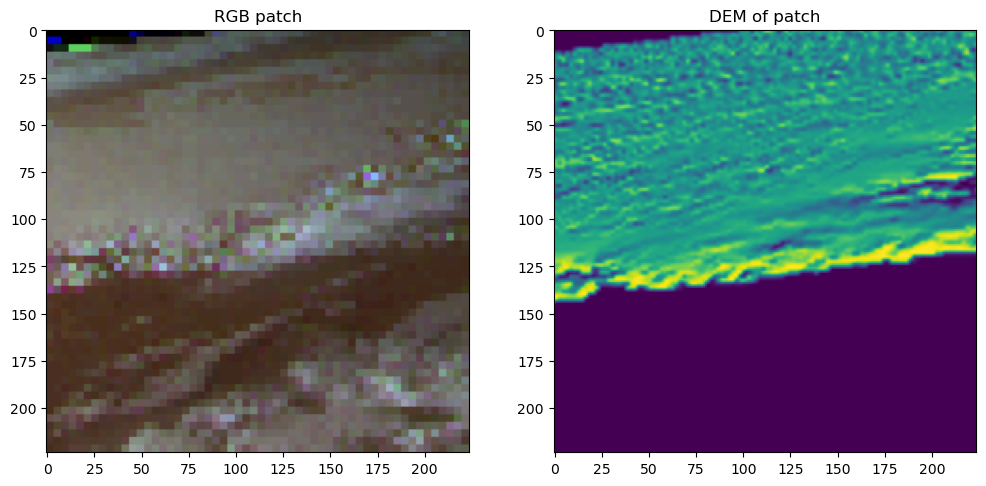

In [39]:
patch_ = tff.imread(your_current_dir+'/all_patch_folder_ZSA/patches_rgb_aux_electro_l2_1700/patch_21.tif')
bgr_ = patch_[:,:,:3].astype(np.uint8)
dem_ = patch_[:,:,-1]
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(bgr_)
ax[1].imshow(dem_)
ax[0].set_title('RGB patch')
ax[1].set_title('DEM of patch')
plt.show()

**ELECTRO PATCHES DATASET CLASS**

In [33]:
import glob
class Electro_L2_Dataset(Dataset):
    def __init__(self, stack_dir_list):
        super().__init__()
        self.stack_dir_list = stack_dir_list
        self.non_empty_list = []
        self.snowy_list = []
        self.stack_dirs = []
        self.stack_dirs_BT = []
        self.all_snow_flags = []
        self.non_empty_snow_idxs = []
        for i in range(len(self.stack_dir_list)): # iterate over number of pictures in dataset
            stack_dir = self.stack_dir_list[i]
            stack_dir_BT = self.stack_dir_list[i].replace('rgb_aux', 'BT').replace('folder_ZSA','folder_BT')
            non_empty_idxs_dir = self.stack_dir_list[i].replace('all_patch_folder_ZSA','nonempty_idxs_folder_ZSA')
            non_empty_idxs_dir = non_empty_idxs_dir.replace('patches_rgb_aux','nonempty_idxs')
            patch_files = glob.glob(stack_dir+'/*')
            patch_files_BT = glob.glob(stack_dir_BT+'/*')
            for j in range(len(patch_files)):
                patch_file = stack_dir+'/patch_'+str(j)+'.tif'
                self.stack_dirs.append(patch_file)
                patch_file_BT = patch_file.replace('rgb_aux', 'BT').replace('folder_ZSA','folder_BT')
                self.stack_dirs_BT.append(patch_file_BT)        
    def __len__(self):
        num_patches = int((len(self.stack_dirs))) 
        return num_patches
    def open_rgb_aux_normed(self, idx, invert=False):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        b,g,r = patch[:,:,0]/255, patch[:,:,1]/255, patch[:,:,2]/255
        lon, lat, dem = patch[:,:,-3], patch[:,:,-2], patch[:,:,-1]/288.2
        lon,lat = (lon+180.0)/360.0,(lat+90.0)/180.0
        patch_normed  = np.dstack([b, g ,r, lon, lat, dem])
        return patch_normed 
    def open_BT_normed(self, idx, invert=False):
        patch_file_BT = self.stack_dirs_BT[idx]
        patch_BT = tff.imread(patch_file_BT)
        return patch_BT 
    def open_lonlat(self, idx, invert=False):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        lon,lat = patch[:,:,-3],patch[:,:,-2]
        lon,lat = (lon+180.0)/360.0,(lat+90.0)/180.0
        lonlat_normed = np.dstack((lon,lat))
        return lonlat_normed
    def open_dem(self, idx, invert=False):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        dem_arr = patch[:,:,-1]/288.2 # normalization altitude to range [0...1]
        return torch.tensor(dem_arr, dtype=torch.float32).unsqueeze(2)
    def __getitem__(self, idx):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        b,g,r = patch[:,:,0]/255, patch[:,:,1]/255, patch[:,:,2]/255
        lon, lat, dem = patch[:,:,-3], patch[:,:,-2], patch[:,:,-1]/288.2
        lon, lat = (lon+180.0)/360.0,(lat+90.0)/180.0
        patch_normed  = np.stack([b, g ,r, lon, lat, dem])
        patch_file_BT = self.stack_dirs_BT[idx]
        BT_normed = tff.imread(patch_file_BT).transpose(2,0,1)
        full_stack = np.concatenate((patch_normed, BT_normed), axis=0)
        full_stack = torch.tensor(full_stack, dtype=torch.float32)
        return full_stack
    def open_as_pil(self, idx):
        patch_file = self.stack_dirs[idx]
        patch_image = tff.imread(patch_file)
        patch_to_show = np.dstack((patch_image[:,:,2], patch_image[:,:,1], patch_image[:,:,0])).astype(np.uint8)
        return patch_to_show  

**INITIALIZE DATASET PATH AND CHECK IF ITS NORMALLY PROCESSED**

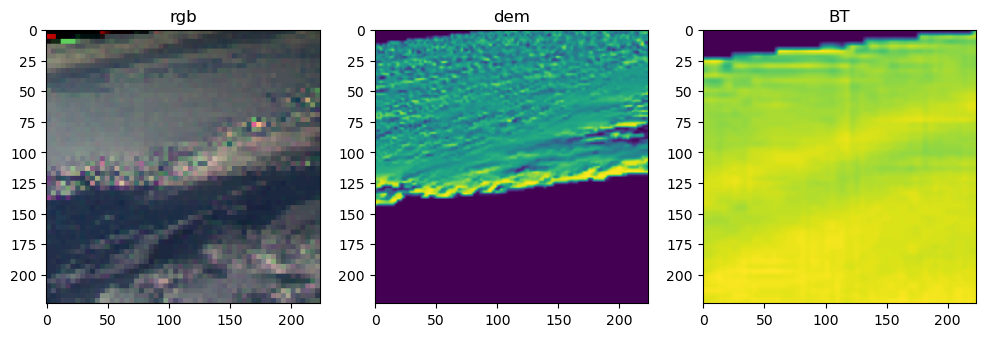

(torch.Size([12, 224, 224]), 2304)

In [34]:
stack_dir = [your_current_dir+'/all_patch_folder_ZSA/patches_rgb_aux_electro_l2_'+time]
Electro_L2_ds = Electro_L2_Dataset(stack_dir_list=stack_dir)
SAMPLE_INDX =21
x_rgb_lonlat = Electro_L2_ds[SAMPLE_INDX]
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(Electro_L2_ds.open_as_pil(SAMPLE_INDX))
ax[1].imshow(Electro_L2_ds.open_dem(SAMPLE_INDX))
ax[2].imshow(Electro_L2_ds.open_BT_normed(SAMPLE_INDX)[:,:,1])
ax[0].set_title('rgb')
ax[1].set_title('dem')
ax[2].set_title('BT')
plt.show()
x_rgb_lonlat.shape ,len(Electro_L2_ds)

**CREATE A MODEL & LOAD ITS WEIGHTS**

In [10]:
model = smp.MAnet(
    encoder_name = 'efficientnet-b1', 
    in_channels = 12,
    classes = 3,)
model_path = your_current_dir+'/model'
model.load_state_dict(torch.load(model_path))
model.eval()
clear_output()

**CHECK THE MODEL WORK VISUALLY FOR SEVERAL PATCHES OF DATASET**

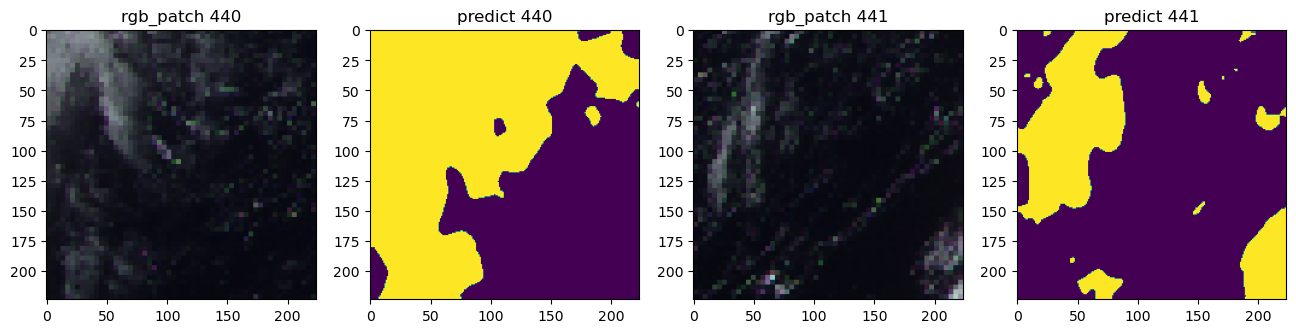

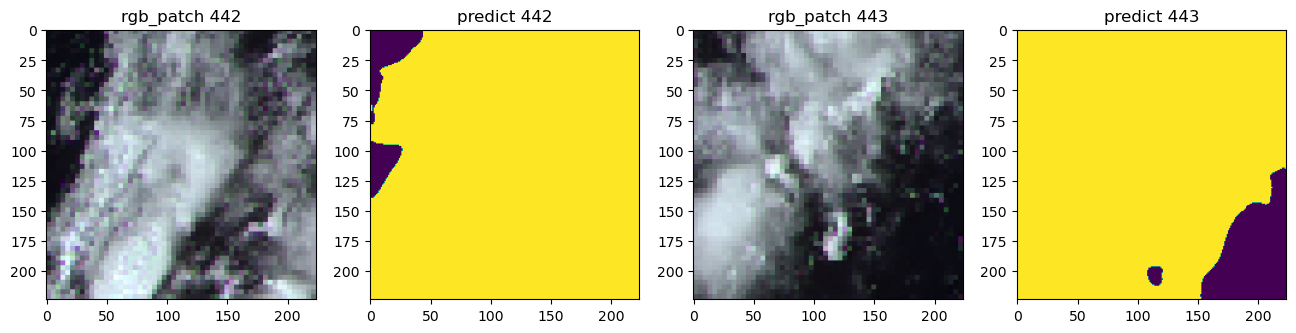

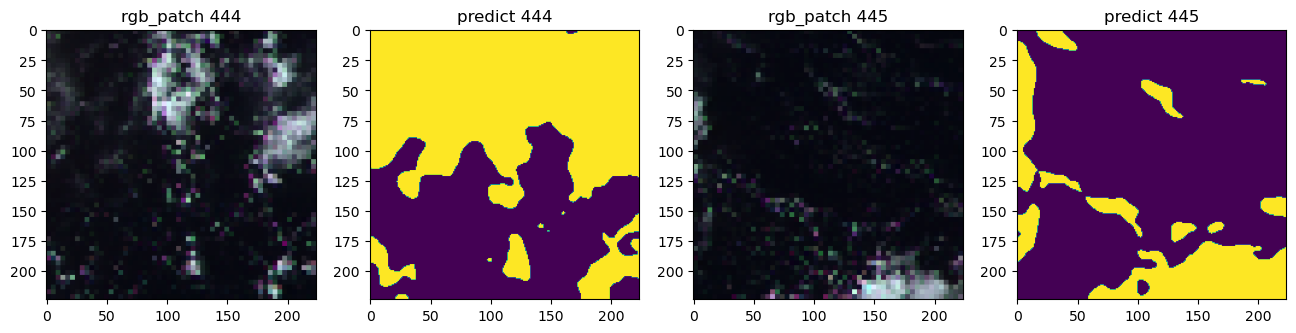

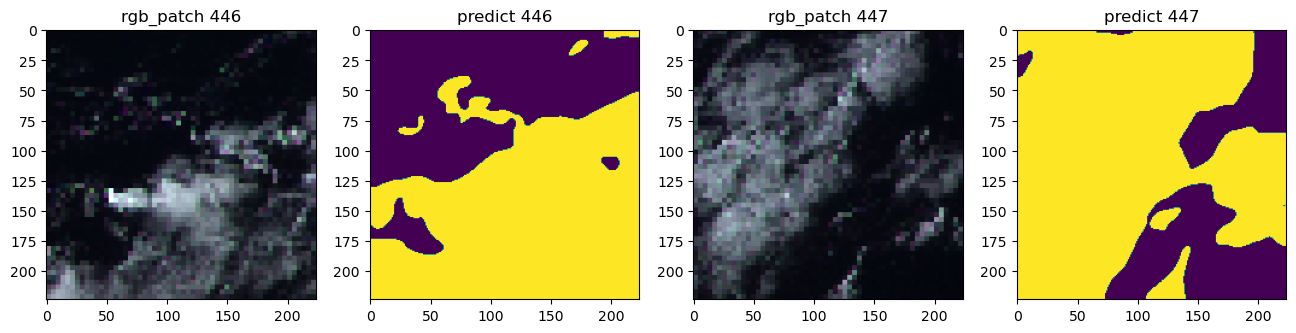

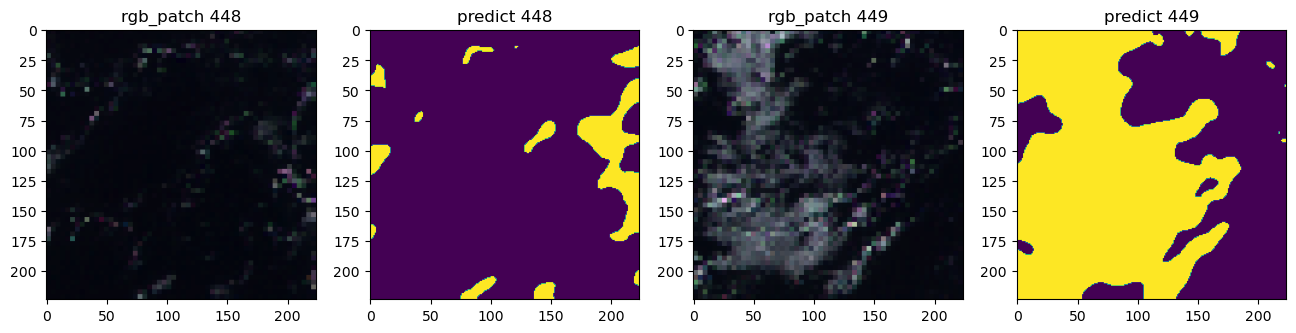

In [35]:
#TESTING DATASET
def visualize_MANet_pred(idx, model, dataset):
    model = model.to(device)
    x_rgb_lonlat = dataset[idx]
    x_rgb_lonlat = x_rgb_lonlat.to(device)
    fig, ax = plt.subplots(1,4, figsize=(16,4))
    cloud_mask = model(x_rgb_lonlat.unsqueeze(0))#
    pred=predb_to_mask(cloud_mask).numpy()
    ax[0].imshow(open_sample_as_pil_no_norm(x_rgb_lonlat.cpu()))
    ax[1].imshow(pred)
    ax[0].set_title('rgb_patch '+str(idx))
    ax[1].set_title('predict '+str(idx))
    x_rgb_lonlat = dataset[idx+1]#.to(device)
    x_rgb_lonlat = x_rgb_lonlat.to(device)
    cloud_mask = model(x_rgb_lonlat.unsqueeze(0))#
    pred=predb_to_mask(cloud_mask).numpy()
    ax[2].imshow(open_sample_as_pil_no_norm(x_rgb_lonlat.cpu()))
    ax[3].imshow(pred)
    ax[2].set_title('rgb_patch '+str(idx+1))
    ax[3].set_title('predict '+str(idx+1))
    plt.show()
for idx in range(440,450,2):
    visualize_MANet_pred(idx, model, dataset = Electro_L2_ds)

**PROCESS ALL PATCHES AND SAVE PREDICTS TO DIRS TO MERGE IT TO THE FULL EARTH DISK MASK**

In [36]:
def pred_and_save_masks(idx, model,dataset,pred_dir_cloud):
    try:x_rgb_lonlat = dataset[idx]
    except:print('cant open sample number:',idx)
    x_rgb_lonlat = x_rgb_lonlat.to(device)
    cloud_mask = model(x_rgb_lonlat.unsqueeze(0))
    pred=predb_to_mask(cloud_mask).numpy()
    cloud_mask,snow_mask = pred.copy(),pred.copy()
    cloud_mask[cloud_mask!=2] = 0 
    cloud_mask[cloud_mask==2] = 255
    snow_mask[snow_mask!=1] = 0 
    snow_mask[snow_mask==1] = 255
    pred_dir_snow = pred_dir_cloud.replace('cloud', 'snow')
    pred_name_cloud = pred_dir_cloud + 'patch_'+str(idx)+'.jpg'
    pred_name_snow = pred_dir_snow + 'patch_'+str(idx)+'.jpg'
    if not os.path.exists(pred_dir_cloud):
        os.makedirs(pred_dir_cloud)
    if not os.path.exists(pred_dir_snow):
        os.makedirs(pred_dir_snow)
    tff.imsave(pred_name_cloud,cloud_mask)
    tff.imsave(pred_name_snow,snow_mask)
pred_dir_cloud = your_current_dir+'/patches_predict_cloud/'
for idx in tqdm(range(len(Electro_L2_ds))):
    pred_and_save_masks(idx=idx, model = model,dataset = Electro_L2_ds,pred_dir_cloud = pred_dir_cloud)

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [02:20<00:00, 16.37it/s]


**MERGE AND VISUALIZE PREDICT**

100%|█████████████████████████████████████████████████████████████████████████████| 2304/2304 [00:19<00:00, 120.87it/s]


merged_mask.shape =  (10752, 10752)


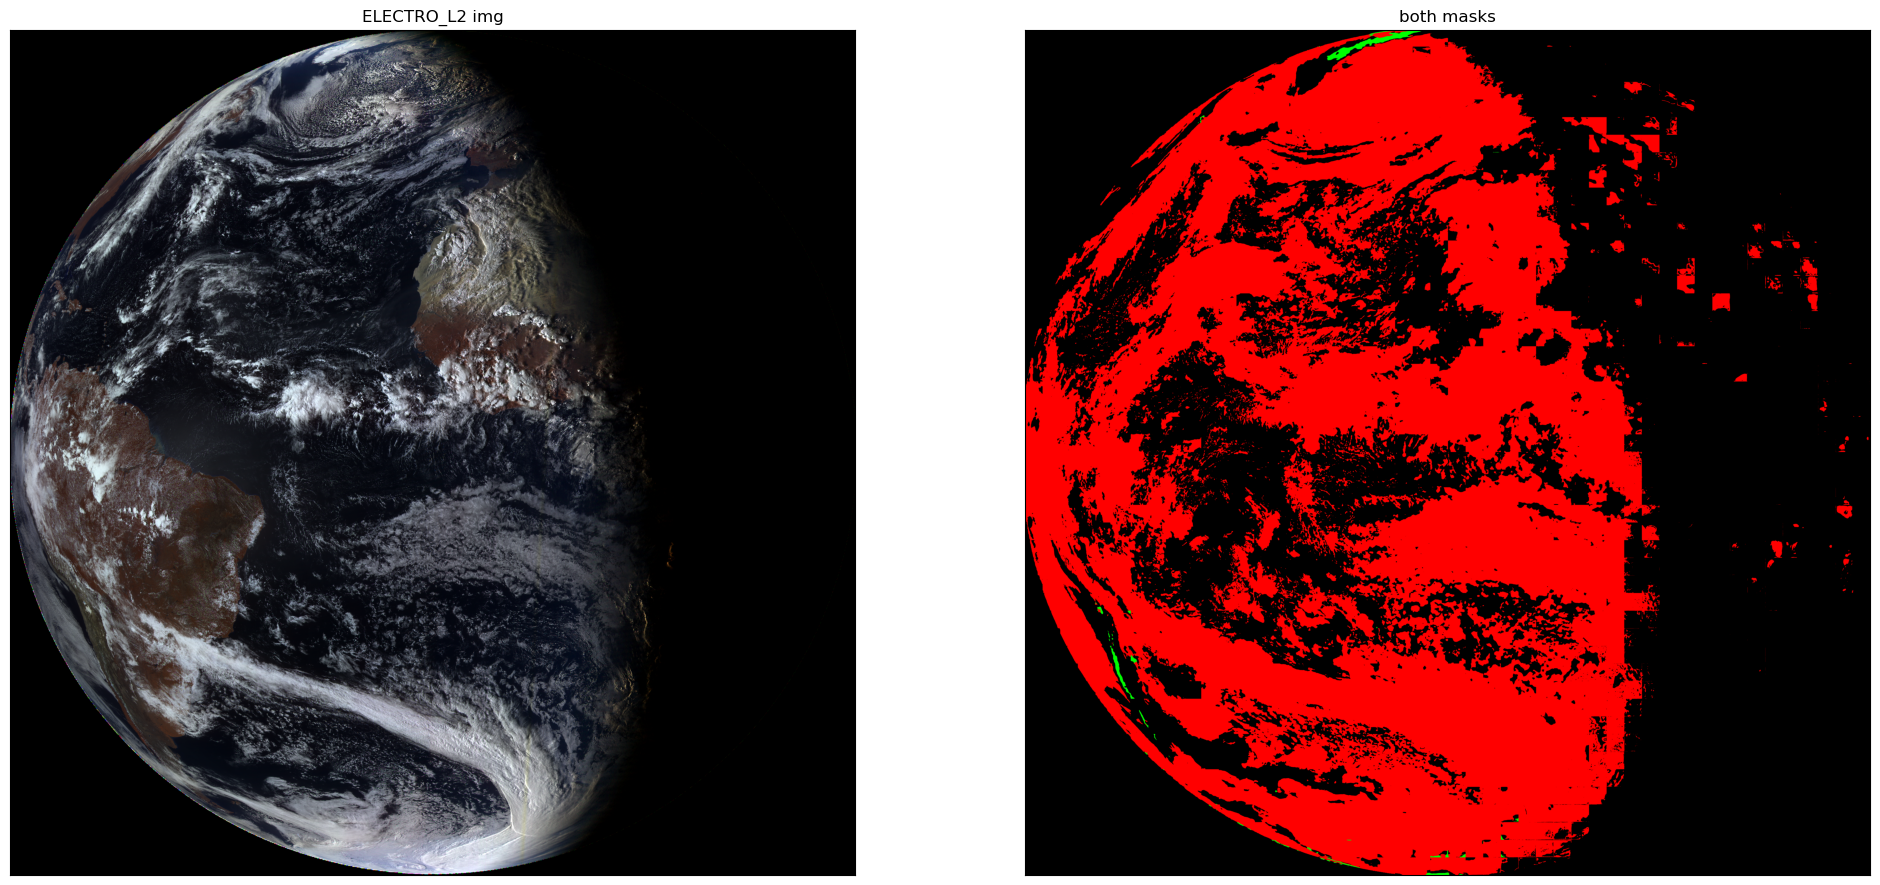

In [37]:
def merge_masks(patches_folder, output_file,output_shape, save_mode = False):
    output_matrix = np.zeros(output_shape, dtype=np.uint8)
    # Loop through each patch and insert it into the output matrix
    for i in tqdm(range(2304)):
        patch_file = f"{patches_folder}/patch_{i}.jpg"
        patch_image = tff.imread(patch_file)
        row = (i // 48) * 224
        col = (i % 48) * 224
        output_matrix[row:row+224, col:col+224] = patch_image
    # Save the output matrix to the specified file
    if save_mode:
        tff.imsave(output_file, output_matrix)
    return output_matrix
rgb_nir = tff.imread( your_current_dir+'/rgb_ZSA_'+time+'.tif')
if rgb_nir.shape[0] == 11136:
    padding = (11136-10848)//2
elif rgb_nir.shape[0] == 10848 or rgb_nir.shape[0] == 10848//2:
    padding = 0
elif rgb_nir.shape[0] == 2784:
    padding = (11136-10848)//8
else: print('incorrect input img shape!')
if rgb_nir.shape[0] != 10848:
    rgb_nir = rgb_nir[padding:-padding,padding:-padding,:]
    rgb_nir = np.array(Image.fromarray(rgb_nir).resize((10848,10848))).astype(np.uint8)
mask_folder_cloud =  your_current_dir+'/patches_predict_cloud'
merged_mask_file_name_cloud = mask_folder_cloud + '.jpg'
mask_folder_snow = mask_folder_cloud.replace('cloud','snow')
merged_mask_file_name_snow = mask_folder_snow + '.jpg'
merged_shape = (10752, 10752)
merged_mask_cloud = merge_masks(mask_folder_cloud,output_file = merged_mask_file_name_cloud,output_shape = merged_shape)
merged_mask_snow = merge_masks(mask_folder_snow,output_file = merged_mask_file_name_snow,output_shape = merged_shape)
print('merged_mask.shape = ',merged_mask_cloud.shape)
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(rgb_nir)
bg = np.zeros((10752, 10752), dtype=np.uint8)
ax[1].imshow(np.dstack((merged_mask_cloud,merged_mask_snow,bg)))
ax[0].set_title('ELECTRO_L2 img')
ax[1].set_title('both masks')
ax[0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.show()

**COMPUTE METRICS FOR THE FULL IMG PREDICT**

F1 and IoU results of electro l2 MANet tested on GOES-16 mask
Test F1 score: 0.9062, Test IoU: 0.7350
Test FAR: 0.0938
Test F1 score for each class (bg, cloud, snow): [0.909946  0.903166  0.7069523], 
Test IoU for each class (bg, cloud, snow): [0.83477145 0.82343    0.5467333 ]


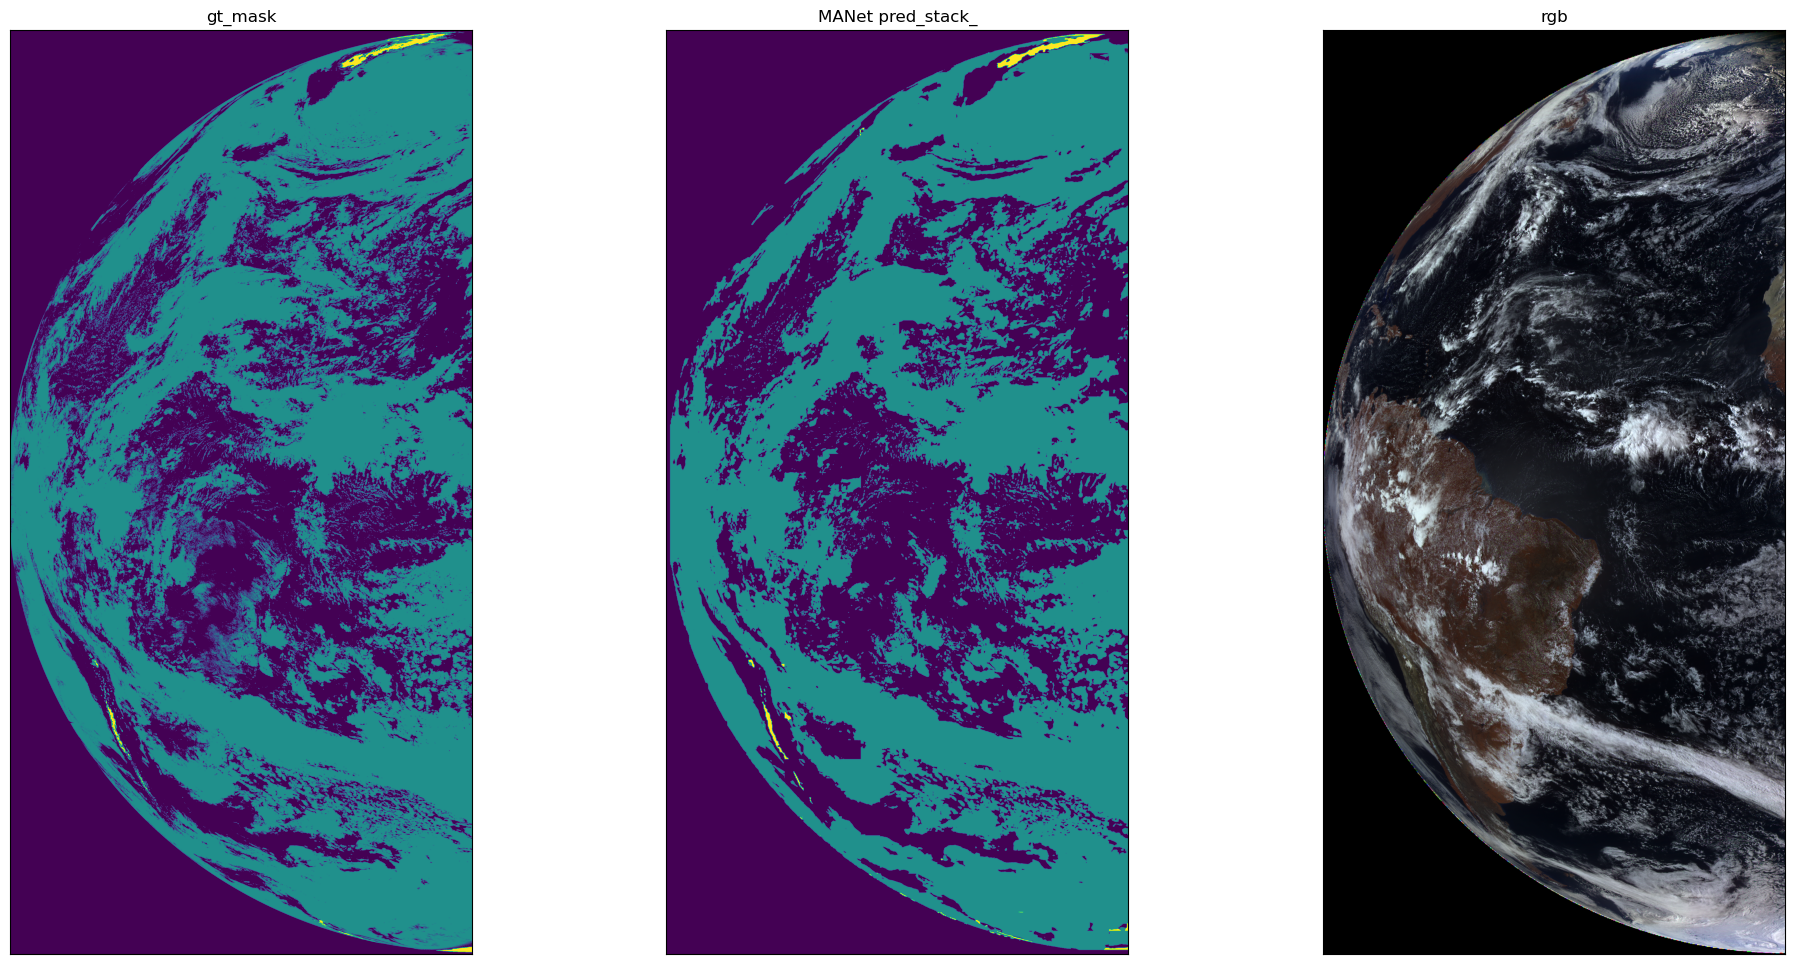

In [38]:
#reshaping predict of MANet to 5424 2 km res
Levir_style = False
snow_mask_ = np.array(Image.fromarray(merged_mask_snow).resize((10752//2,10752//2),resample=Image.NEAREST)).astype(np.uint8)
cloud_mask_ = np.array(Image.fromarray(merged_mask_cloud).resize((10752//2,10752//2),resample=Image.NEAREST)).astype(np.uint8)
if Levir_style:
    snow_mask = np.pad(cloud_mask_,((24,24),(24,24)))
    cloud_mask = np.pad(snow_mask_,((24,24),(24,24)))
    snow_mask[snow_mask!=0] = 1
    cloud_mask[cloud_mask!=0] = 2
else:
    snow_mask = np.pad(snow_mask_,((24,24),(24,24)))
    cloud_mask = np.pad(cloud_mask_,((24,24),(24,24)))
    snow_mask[snow_mask!=0] = 2
    cloud_mask[cloud_mask!=0] = 1
snow_mask.shape, cloud_mask.shape, np.unique(snow_mask), np.unique(cloud_mask)
try:cloud_goes = tff.imread(your_current_dir+'/cloud_mask_geos2geos_reprojected_'+time+'.jpg')
except: cloud_goes = tff.imread(your_current_dir+'/cloud_mask_reprojected_'+time+'.jpg')#np.zeros((5424,5424))
snow_map = tff.imread(your_current_dir+'/snow_map.jpg')
false_snow = ((snow_map/255)*(cloud_goes/255)*255).astype(np.uint8)
true_snow_mask = snow_map-false_snow
#print('unique true_snow_mask:', np.unique(true_snow_mask))
check = true_snow_mask*cloud_goes
#print('check overlapping (should be zeros):', np.unique(check))
if Levir_style:
    true_snow_mask[true_snow_mask!=0] = 1
    cloud_goes[cloud_goes!=0] = 2
else:
    true_snow_mask[true_snow_mask!=0] = 2
    cloud_goes[cloud_goes!=0] = 1
gt_mask = cloud_goes+true_snow_mask
test_f1_score = torchmetrics.F1Score(num_classes=3, task = 'multiclass')
test_iou_score = torchmetrics.JaccardIndex(num_classes=3, task = 'multiclass')
test_f1_score_sep = torchmetrics.F1Score(num_classes=3, task = 'multiclass', average = None)
test_iou_score_sep = torchmetrics.JaccardIndex(num_classes=3, task = 'multiclass', average = None)
test_acc = torchmetrics.Accuracy(num_classes=3, task = 'multiclass')
#######################################
pred_stack_ = snow_mask + cloud_mask
predictions = torch.tensor(pred_stack_)[:,:2712]
y = torch.tensor(gt_mask)[:,:2712]
test_f1_score.update(predictions, y)
test_iou_score.update(predictions, y)
test_f1_score_sep.update(predictions, y)
test_iou_score_sep.update(predictions, y)
test_acc.update(predictions, y)
############################
test_f1 = test_f1_score.compute()
test_iou = test_iou_score.compute()
test_acc = test_acc.compute()
#calculate the same metrics seperately for each class
test_f1_sep = test_f1_score_sep.compute()
test_iou_sep = test_iou_score_sep.compute()
FAR = 1 - test_acc
# printing the results
if Levir_style: print('F1 and IoU results of electro l2 U-Net++ tested on GOES-16 mask')
else: print('F1 and IoU results of electro l2 MANet tested on GOES-16 mask')
print(f"Test F1 score: {test_f1:.4f}, Test IoU: {test_iou:.4f}")
print(f"Test FAR: {FAR:.4f}")
print(f"Test F1 score for each class (bg, cloud, snow): {test_f1_sep.numpy()}, \nTest IoU for each class (bg, cloud, snow): {test_iou_sep.numpy()}")
fig, ax = plt.subplots(1,3, figsize=(24,12))
ax[0].imshow(gt_mask[:,:2712])
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax[0].set_title('gt_mask')
ax[1].imshow(pred_stack_[:,:2712])
if Levir_style:ax[1].set_title('U-Net++ pred_stack_')
else:ax[1].set_title('MANet pred_stack_')
ax[2].imshow(rgb_nir[:,:2712*2,:])
ax[2].set_title('rgb')
# hide ticks on plots
ax[0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
ax[2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.show()